In [1]:
import numpy as np
import pickle

class ScoreRanker:
    """
    Analyzes raw training dynamics scores and sorts data samples from easiest to hardest.

    This class uses the same underlying logic as the Evaluator to determine what 
    constitutes a "hard" example for each metric, but instead of binarizing, it
    returns the sorted indices of the samples. This is useful for rank-based
    analysis like Spearman's correlation.

    The output for each metric is a list of arrays, where each array contains the
    indices of the dataset sorted from easiest to hardest for a given epoch.
    """
    def __init__(self, stats):
        """
        Initializes the ranker and processes the stats.

        Args:
            stats (dict): A dictionary containing the raw scores for various metrics,
                          e.g., {"aum": [...], "el2n": [...], ...}.
        """
        self.ranked_indices_by_method = {}
        self._rank(stats)

    def get_ranked_indices(self):
        """
        Returns the dictionary of ranked indices for all processed metrics.
        """
        return self.ranked_indices_by_method

    def _rank(self, stats):
        """
        Routes stats to the appropriate ranking method based on available keys.
        """
        if "aum" in stats:
            self.ranked_indices_by_method["aum"] = self._rank_by_aum(stats["aum"])
        if "datamap" in stats:
            self.ranked_indices_by_method["datamap"] = self._rank_by_datamap(stats["datamap"])
        if "el2n" in stats:
            self.ranked_indices_by_method["el2n"] = self._rank_by_el2n(stats["el2n"])
        # if "grand" in stats:
        #     self.ranked_indices_by_method["grand"] = self._rank_by_grand(stats["grand"])
        if "loss" in stats:
            self.ranked_indices_by_method["loss"] = self._rank_by_loss(stats["loss"])
        if "forgetting" in stats:
            self.ranked_indices_by_method["forgetting"] = self._rank_by_forgetting(stats["forgetting"])
        if "predictions" in stats and "true_labels" in stats:
             accuracy_scores = (np.array(stats['predictions']) == np.array(stats['true_labels'])).astype(int)
             self.ranked_indices_by_method["accuracy"] = self._rank_by_accuracy(accuracy_scores)

    def _rank_by_aum(self, aum_scores):
        """
        Ranks by AUM. Lower scores are harder.
        Sorts scores in descending order (easy to hard).
        """
        ranked_indices_over_epochs = []
        for epoch_scores in aum_scores:
            scores = np.array(epoch_scores, dtype=float)
            # Lower scores are harder, so NaNs are treated as infinitely hard (-np.inf)
            scores[np.isnan(scores)] = -np.inf 
            # argsort on negative array sorts in descending order
            ranked_indices = np.argsort(-scores)
            ranked_indices_over_epochs.append(ranked_indices)
        return ranked_indices_over_epochs

    def _rank_by_el2n(self, el2n_scores):
        """
        Ranks by EL2N. Higher scores are harder.
        Sorts scores in ascending order (easy to hard).
        """
        ranked_indices_over_epochs = []
        for epoch_scores in el2n_scores:
            scores = np.array(epoch_scores, dtype=float)
            # Higher scores are harder, so NaNs are treated as infinitely hard (np.inf)
            scores[np.isnan(scores)] = np.inf
            ranked_indices = np.argsort(scores)
            ranked_indices_over_epochs.append(ranked_indices)
        return ranked_indices_over_epochs

    def _rank_by_grand(self, grand_scores):
        """
        Ranks by GraND. Higher scores are harder.
        Sorts scores in ascending order (easy to hard).
        """
        return self._rank_by_el2n(grand_scores) # Same logic as EL2N

    def _rank_by_loss(self, loss_scores):
        """
        Ranks by Loss. Higher loss is harder.
        Sorts scores in ascending order (easy to hard).
        """
        ranked_indices_over_epochs = []
        for epoch_loss_obj_array in loss_scores:
            scores = np.array([item[0] if item else np.nan for item in epoch_loss_obj_array], dtype=float)
            # Higher scores are harder, so NaNs are treated as infinitely hard (np.inf)
            scores[np.isnan(scores)] = np.inf
            ranked_indices = np.argsort(scores)
            ranked_indices_over_epochs.append(ranked_indices)
        return ranked_indices_over_epochs

    def _rank_by_datamap(self, datamap_stats):
        """
        Ranks by Data Map confidence and variability.
        Low confidence and high variability are harder.
        We create a composite score: variability - confidence.
        Sorts composite score in ascending order (easy to hard).
        """
        confidence_scores = datamap_stats['confidence']
        variability_scores = datamap_stats['variability']
        ranked_indices_over_epochs = []

        for conf_epoch, var_epoch in zip(confidence_scores, variability_scores):
            conf = np.array(conf_epoch, dtype=float)
            var = np.array(var_epoch, dtype=float)
            
            # Composite score where lower is easier (high confidence, low variability)
            composite_score = var - conf
            composite_score[np.isnan(composite_score)] = np.inf
            
            ranked_indices = np.argsort(composite_score)
            ranked_indices_over_epochs.append(ranked_indices)
            
        return ranked_indices_over_epochs

    def _rank_by_forgetting(self, forgetting_scores):
        """
        Ranks by forgetting events. More forgetting is harder.
        'Never learned' (-1) is considered the hardest.
        Sorts scores in ascending order (easy to hard).
        """
        ranked_indices_over_epochs = []
        for forgetting_counts in forgetting_scores:
            scores = np.array(forgetting_counts, dtype=float)
            # Find a value larger than any real count to represent 'never learned'
            hardest_val = np.max(scores) + 1 if scores.size > 0 else 1
            # Map -1 (never learned) to this hardest value for sorting
            scores[scores == -1] = hardest_val
            
            ranked_indices = np.argsort(scores)
            ranked_indices_over_epochs.append(ranked_indices)
        return ranked_indices_over_epochs

    def _rank_by_accuracy(self, accuracy_scores):
        """
        Ranks by cumulative accuracy. Lower accuracy is harder.
        Sorts scores in descending order (easy to hard).
        """
        ranked_indices_over_epochs = []
        for epoch_idx in range(len(accuracy_scores)):
            cumulative_data = accuracy_scores[:epoch_idx + 1]
            max_len = max(len(row) for row in cumulative_data)
            
            padded_data = np.full((len(cumulative_data), max_len), np.nan, dtype=float)
            for i, row in enumerate(cumulative_data):
                padded_data[i, :len(row)] = row
            
            avg_accuracy = np.nanmean(padded_data, axis=0)
            
            # Lower accuracy is harder, so NaNs are treated as infinitely hard (-np.inf)
            avg_accuracy[np.isnan(avg_accuracy)] = -np.inf
            
            # argsort on negative array sorts in descending order
            ranked_indices = np.argsort(-avg_accuracy)
            ranked_indices_over_epochs.append(ranked_indices)
        return ranked_indices_over_epochs

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from itertools import combinations_with_replacement

class CorrelationAnalysis:
    """
    Calculates and visualizes the Spearman's rank correlation between different
    data hardness metrics.
    """
    def __init__(self, ranked_indices_by_method):
        """
        Initializes the analysis with ranked indices from the ScoreRanker.

        Args:
            ranked_indices_by_method (dict): The output from ScoreRanker.get_ranked_indices().
        """
        if not ranked_indices_by_method:
            raise ValueError("The input dictionary 'ranked_indices_by_method' is empty.")
            
        self.ranked_indices = ranked_indices_by_method
        self.methods = list(self.ranked_indices.keys())
        # Assuming number of epochs is consistent across all methods
        self.num_epochs = len(next(iter(self.ranked_indices.values())))
        self.avg_corr_matrix = None

    @staticmethod
    def _get_ranks_from_sorted_indices(sorted_indices):
        """
        Converts a list of sorted indices into a rank array.
        Example: [2, 0, 1] -> [1, 2, 0]
        (Item 2 is rank 0, item 0 is rank 1, item 1 is rank 2)
        """
        if len(sorted_indices) == 0:
            return np.array([])
        ranks = np.empty_like(sorted_indices)
        ranks[sorted_indices] = np.arange(len(sorted_indices))
        return ranks

    def calculate_average_correlation_matrix(self):
        """
        Computes the pairwise Spearman correlation between all methods,
        averaged over all epochs.
        """
        num_methods = len(self.methods)
        # Initialize a matrix to accumulate correlation scores over epochs
        total_corr_matrix = np.zeros((num_methods, num_methods))
        
        for epoch in range(self.num_epochs):
            # For each pair of methods (m1, m2)
            for i, j in combinations_with_replacement(range(num_methods), 2):
                method1 = self.methods[i]
                method2 = self.methods[j]

                # Get the sorted indices for the current epoch
                indices1 = self.ranked_indices[method1][epoch]
                indices2 = self.ranked_indices[method2][epoch]

                # Ensure we have data to compare
                if len(indices1) != len(indices2) or len(indices1) < 2:
                    continue

                # Convert sorted indices to ranks for correlation calculation
                ranks1 = self._get_ranks_from_sorted_indices(indices1)
                ranks2 = self._get_ranks_from_sorted_indices(indices2)

                # Calculate Spearman's correlation
                corr, _ = spearmanr(ranks1, ranks2)
                
                # A correlation can be nan if the input is constant, default to 0
                if np.isnan(corr):
                    corr = 0.0

                if i == j:
                    total_corr_matrix[i, j] += 1.0
                else:
                    total_corr_matrix[i, j] += corr
                    total_corr_matrix[j, i] += corr
        
        # Average the correlations over the number of epochs
        self.avg_corr_matrix = total_corr_matrix / self.num_epochs
        return self.avg_corr_matrix

    def plot_heatmap(self, title="Average Spearman's Correlation Across 10 Runs (RoBERTa-Large on QQP)"):
        """
        Generates and displays a heatmap of the average correlation matrix.
        """
        if self.avg_corr_matrix is None:
            print("Correlation matrix not calculated. Running calculation now...")
            self.calculate_average_correlation_matrix()

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            self.avg_corr_matrix,
            xticklabels=self.methods,
            yticklabels=self.methods,
            annot=True,        # Display the correlation values
            fmt=".2f",         # Format values to two decimal places
            cmap="vlag",       # Use a diverging colormap (blue-white-red)
            vmin=-1, vmax=1    # Set the color scale from -1 to 1
        )
        plt.title(title, fontsize=16)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.show()


import os
import pickle
# import matplotlib
# matplotlib.use('Agg')  # Use a non-interactive backend

# import matplotlib.pyplot as plt

# Define the base directory where your model runs are stored
base_dir = '/vol/bitbucket/hrm20/fyp/artifacts/xlnet_base_fever/'

# Create a list of all run file paths
run_files = [os.path.join(base_dir, f"run{i}.pkl") for i in range(1, 11)]

# Load the raw scores from each run into a list
all_run_stats = []
for file_path in run_files:
    try:
        with open(file_path, "rb") as f:
            eval_summary = pickle.load(f)
            all_run_stats.append(eval_summary["raw_scores"])
    except FileNotFoundError:
        print(f"Warning: File not found at {file_path}. Skipping.")


# Assume ScoreRanker and CorrelationAnalysis classes are defined as before

# A list to hold the correlation matrix from each run
correlation_matrices = []
method_names = None # To store the order of methods

print(f"Analyzing {len(all_run_stats)} runs...")
for i, stats in enumerate(all_run_stats):
    print(f"Processing run {i+1}...")
    
    # 1. Get ranked indices for the current run
    ranker = ScoreRanker(stats)
    ranked_indices = ranker.get_ranked_indices()
    
    # 2. Calculate the correlation matrix for the current run
    corr_analyzer = CorrelationAnalysis(ranked_indices)
    corr_matrix = corr_analyzer.calculate_average_correlation_matrix()
    
    # Store the resulting matrix
    correlation_matrices.append(corr_matrix)
    
    # Store the method names (they should be the same for all runs)
    if method_names is None:
        method_names = corr_analyzer.methods

# --- Averaging Step ---
if correlation_matrices:
    # Convert the list of 2D matrices into a single 3D NumPy array
    # Shape will be (num_runs, num_methods, num_methods)
    stacked_matrices = np.array(correlation_matrices)

    # Calculate the mean across the 'runs' axis (axis=0)
    final_avg_matrix = np.mean(stacked_matrices, axis=0)
    
    # (Optional but recommended) Calculate the standard deviation
    final_std_matrix = np.std(stacked_matrices, axis=0)

    print("\nFinal Average Correlation Matrix:")
    print(final_avg_matrix)

    # 3. Plot the final averaged heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        final_avg_matrix,
        xticklabels=method_names,
        yticklabels=method_names,
        annot=True,
        fmt=".2f",
        cmap="vlag",
        vmin=-1, vmax=1,
        annot_kws={"size": 14}
    )
    plt.title("Average Spearman's Correlation Across 10 Runs (XLNet-Base on Fever)", fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("correlation_heatmap.png", dpi=300)
    plt.close()

    # (Optional) Plot the standard deviation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        final_std_matrix,
        xticklabels=method_names,
        yticklabels=method_names,
        annot=True,
        fmt=".2f",
        cmap="viridis_r",
        vmin=0.0,
        vmax=0.25,
        annot_kws={"size": 14}
    )
    plt.title("Standard Deviation of Spearman's Correlation Across 10 Runs (XLNet-Base on Fever)", fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("sd_heatmap.png", dpi=300)
    plt.close()

else:
    print("No correlation matrices were calculated.")

Analyzing 10 runs...
Processing run 1...
Processing run 2...
Processing run 3...
Processing run 4...
Processing run 5...
Processing run 6...
Processing run 7...
Processing run 8...
Processing run 9...
Processing run 10...

Final Average Correlation Matrix:
[[1.         0.69644791 0.99886728 0.99740129 0.27858637 0.43446476]
 [0.69644791 1.         0.69827263 0.69900429 0.27850671 0.63048398]
 [0.99886728 0.69827263 1.         0.99945824 0.27842426 0.43488742]
 [0.99740129 0.69900429 0.99945824 1.         0.2779625  0.43486094]
 [0.27858637 0.27850671 0.27842426 0.2779625  1.         0.18649546]
 [0.43446476 0.63048398 0.43488742 0.43486094 0.18649546 1.        ]]


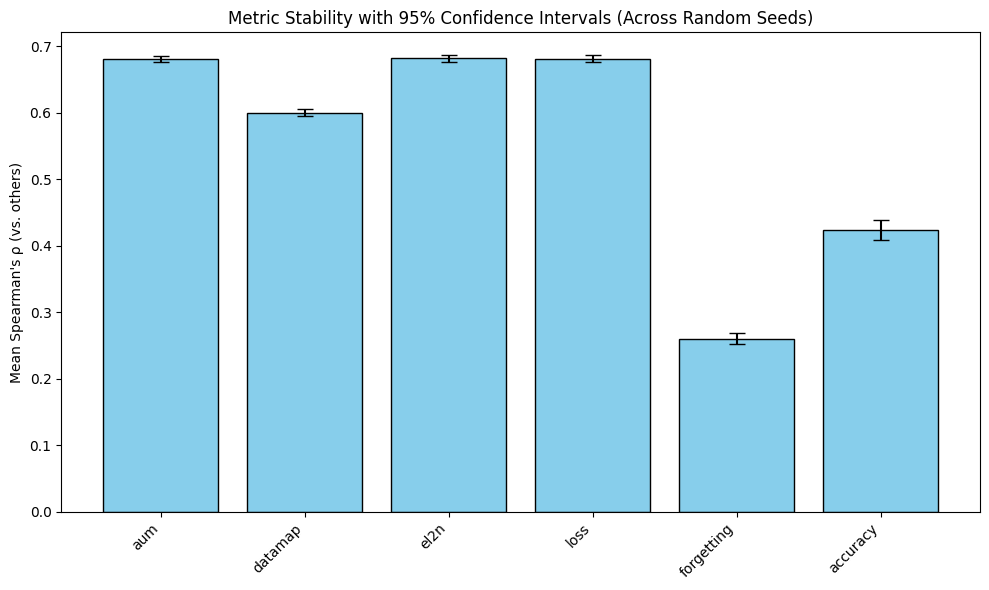

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem, t

# Step 1: Collapse the correlation matrix diagonals (self-correlation) and symmetries
# We'll compute average correlation each metric has with all others
num_runs, num_metrics, _ = stacked_matrices.shape

# Remove self-correlations (diagonal = 1)
for i in range(num_metrics):
    stacked_matrices[:, i, i] = np.nan  # Mask diagonals

# Now compute average correlation of each method with the others (row-wise mean, ignoring NaNs)
mean_per_metric = np.nanmean(stacked_matrices, axis=2)  # Shape: (num_runs, num_metrics)

# Compute mean and 95% CI across runs
means = np.nanmean(mean_per_metric, axis=0)
standard_errors = sem(mean_per_metric, axis=0, nan_policy='omit')
confidence_interval = t.ppf(0.975, df=num_runs - 1) * standard_errors  # 95% CI multiplier

# Plotting
plt.figure(figsize=(10, 6))
x = np.arange(num_metrics)
plt.bar(x, means, yerr=confidence_interval, capsize=6, color='skyblue', edgecolor='black')

plt.xticks(x, method_names, rotation=45, ha='right')
plt.ylabel("Mean Spearman's ρ (vs. others)")
plt.title("Metric Stability with 95% Confidence Intervals (Across Random Seeds)")
plt.tight_layout()
plt.savefig("metric_stability_with_ci.png", dpi=300)
plt.show()
